In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

while 'notebooks' in os.getcwd():
    os.chdir('..')

import torch
import torch_geometric.transforms as T
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from sklearn.metrics import roc_auc_score
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
import numpy as np
import pandas as pd
from sklearn.model_selection import ParameterGrid

from src.torch_geo_models import GraphSAGE, LinkPredictor
from src.data.gamma.positional_citeseer import load_dataset, get_train_val_test_edges_auc,\
    get_val_test_edges_link_pred, prepare_adjencency, get_edge_index_from_adjencency
from src.train.positional_omega.node2vec import PositionalOmegaNode2Vec

/home/caiolmartinelli/.cache/pypoetry/virtualenvs/arxiv-paperclassification-f16XUvnj-py3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
logging.basicConfig(
    format='%(asctime)s - %(levelname)s : %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
    filename='logs/omega_function/citeseer/07-1-positional_omega_node2vec_cossim.log'
)

In [4]:
torch.cuda.is_available()

True

In [5]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
device

device(type='cuda', index=0)

## Data Loading

In [6]:
dataset = load_dataset()

data, edges_train_auc, edges_val_auc, edges_test_auc =\
    get_train_val_test_edges_auc(dataset, device=device)

data, edges_val, edges_test, neg_edges_val, neg_edges_test, neg_edges_train =\
    get_val_test_edges_link_pred(data, remove_from_data=True, device=device, get_neg_edges_train=True)

data = prepare_adjencency(data, to_symmetric=True)

edge_index = get_edge_index_from_adjencency(data, device)

## Training

In [7]:
pq_space = np.logspace(-1, 1, 5).round(2)
pq_space

array([ 0.1 ,  0.32,  1.  ,  3.16, 10.  ])

In [8]:
omega = PositionalOmegaNode2Vec(
                device,
                dataset,
                edge_index,
                data.num_nodes,
                1,
                1,
                run=0)

In [9]:
for run in range(5):
    for p in pq_space:
        for q in pq_space:
            omega = PositionalOmegaNode2Vec(
                device,
                'citeseer',
                edge_index,
                data.num_nodes,
                p,
                q,
                run=run)
            torch.cuda.empty_cache()
            omega.train(edge_index,
                        edges_val,
                        edges_test,
                        neg_edges_train,
                        neg_edges_val,
                        neg_edges_test,
                        edges_train_auc,
                        edges_val_auc,
                        edges_test_auc,
                        data.y)
            omega.discard_run_not_optimal_models()

## Results

### For a layer number

In [10]:
pq_space = np.logspace(-1, 1, 5).round(2)
param_grid = ParameterGrid({
    'p': pq_space,
    'q': pq_space,
})

In [11]:
chosen_param = param_grid[20]
chosen_param

{'q': 0.1, 'p': 10.0}

In [12]:
metrics = PositionalOmegaNode2Vec.read_metrics(
    dataset='citeseer',
    **chosen_param
)
metrics['node2vec_loss'] = metrics['node2vec_loss'].replace('None', np.nan).astype(float)
print(metrics.shape)
metrics.head()

(255, 11)


,p,q,run,epoch,node2vec_loss,loss_train,loss_val,loss_test,auc_train,auc_val,auc_test
0,10.0,0.1,0,0,NaN,1.402597,1.364799,1.395719,0.467678,0.526882,0.509571
1,10.0,0.1,0,10,4.259023,1.382862,1.351846,1.372137,0.461352,0.523315,0.506997
2,10.0,0.1,0,20,3.476300,1.366308,1.340083,1.353579,0.464585,0.514030,0.503782
3,10.0,0.1,0,30,3.000857,1.353852,1.330513,1.341090,0.472199,0.512660,0.503996
4,10.0,0.1,0,40,2.639291,1.344435,1.322891,1.333291,0.479861,0.522178,0.507903


### Sumarize metrics per epoch

In [13]:
metrics_cols = metrics.columns[3:]
metrics_cols

Index(['epoch', 'node2vec_loss', 'loss_train', 'loss_val', 'loss_test',
       'auc_train', 'auc_val', 'auc_test'],
      dtype='object')

In [14]:
metrics['loss_train'] = metrics\
    .replace('None', np.nan)\
    ['loss_train']\
    .astype(float)

In [15]:
epoch_metrics = metrics\
    .fillna(-1)\
    .groupby('epoch')\
    [metrics_cols]\
    .agg(['mean', 'std'])
epoch_metrics.columns = [f'{x[0]}_{x[1]}' for x in epoch_metrics.columns]
epoch_metrics.head()

,epoch_mean,epoch_std,node2vec_loss_mean,node2vec_loss_std,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std
epoch,,,,,,,,,,,,,,,,
0,0.0,0.0,-1.000000,0.000000,1.394751,0.006801,1.385614,0.013878,1.398541,0.009707,0.492195,0.013918,0.513409,0.015086,0.496083,0.012293
10,10.0,0.0,4.244121,0.023951,1.374879,0.006516,1.368233,0.011733,1.377718,0.009039,0.484751,0.013634,0.511899,0.015743,0.490987,0.013444
20,20.0,0.0,3.458522,0.021155,1.358347,0.006423,1.353132,0.010160,1.360477,0.008642,0.481756,0.011887,0.509470,0.014614,0.488686,0.013030
30,30.0,0.0,2.984532,0.015463,1.346055,0.006317,1.341461,0.009238,1.348001,0.007686,0.484449,0.009995,0.510072,0.011719,0.491806,0.011228
40,40.0,0.0,2.632287,0.016160,1.336946,0.006265,1.332732,0.008774,1.339451,0.006649,0.491735,0.009936,0.514010,0.010284,0.497831,0.010027


In [16]:
epoch_metrics.sort_values('auc_val_mean', ascending=False).head()

,epoch_mean,epoch_std,node2vec_loss_mean,node2vec_loss_std,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std
epoch,,,,,,,,,,,,,,,,
90,90.0,0.0,1.621549,0.007323,1.304201,0.005479,1.301433,0.007965,1.311551,0.006167,0.518316,0.003030,0.530038,0.013748,0.524054,0.015225
100,100.0,0.0,1.502230,0.004960,1.297383,0.005214,1.295379,0.007924,1.305747,0.006336,0.517303,0.004144,0.530028,0.015081,0.524097,0.014881
110,110.0,0.0,1.399258,0.008896,1.290394,0.005063,1.289097,0.007892,1.299483,0.006632,0.515597,0.005454,0.529097,0.015549,0.522154,0.014786
80,80.0,0.0,1.757513,0.006134,1.310741,0.005744,1.307525,0.008136,1.317116,0.005837,0.517585,0.004648,0.528893,0.012952,0.521817,0.014709
120,120.0,0.0,1.317670,0.006653,1.283411,0.005095,1.282878,0.007903,1.292771,0.006858,0.512714,0.006394,0.527444,0.016327,0.519926,0.015018


/tmp/ipykernel_2289261/1630125799.py:10: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.

/tmp/ipykernel_2289261/1630125799.py:11: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.

/tmp/ipykernel_2289261/1630125799.py:37: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future

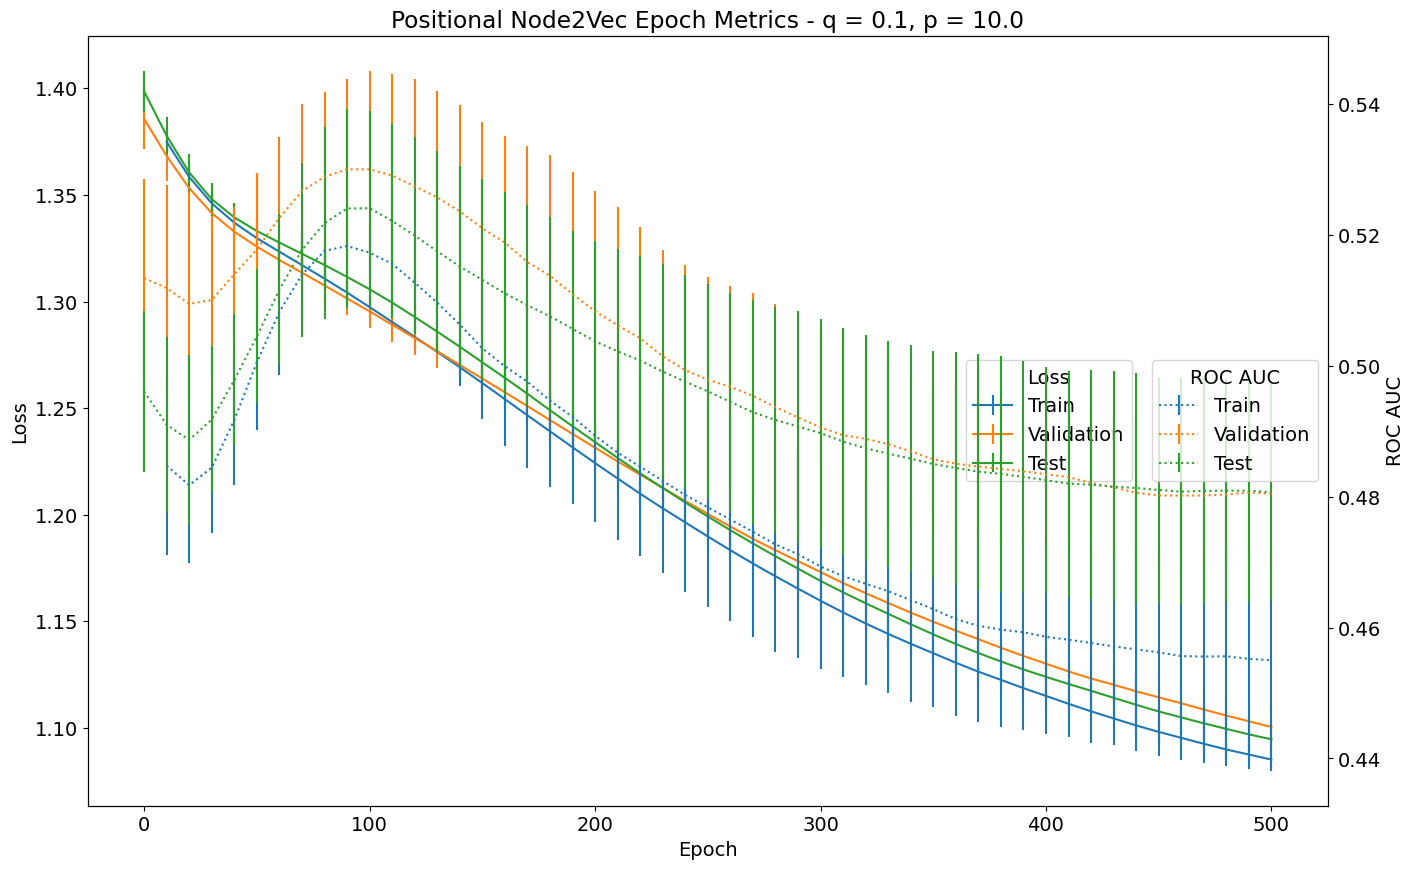

In [17]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

str_desc = ', '.join([f'{k} = {v}' for k, v in chosen_param.items()])

ax1.set_title(f'Positional Node2Vec Epoch Metrics - {str_desc}')

ax1.errorbar(
    epoch_metrics.index[1:],
    epoch_metrics['loss_train_mean'][1:],
    yerr=epoch_metrics['loss_train_std'][1:],
    ls='-',
    label='Train')

ax1.errorbar(
    epoch_metrics.index,
    epoch_metrics['loss_val_mean'],
    yerr=epoch_metrics['loss_val_std'],
    ls='-',
    label='Validation')

ax1.errorbar(
    epoch_metrics.index,
    epoch_metrics['loss_test_mean'],
    yerr=epoch_metrics['loss_test_std'],
    ls='-',
    label='Test')

ax1.legend(loc='center right', title='Loss', bbox_to_anchor=[0.85, 0.5])
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')

ax2 = ax1.twinx()

ax2.errorbar(
    epoch_metrics.index[1:],
    epoch_metrics['auc_train_mean'][1:],
    yerr=epoch_metrics['auc_train_std'][1:],
    ls=':',
    label='Train')

ax2.errorbar(
    epoch_metrics.index,
    epoch_metrics['auc_val_mean'],
    yerr=epoch_metrics['auc_val_std'],
    ls=':',
    label='Validation')

ax2.errorbar(
    epoch_metrics.index,
    epoch_metrics['auc_test_mean'],
    yerr=epoch_metrics['auc_test_std'],
    ls=':',
    label='Test')

ax2.legend(loc='center right', title='ROC AUC', bbox_to_anchor=[1, 0.5])
ax2.set_ylabel('ROC AUC')


str_path_desc = '__'.join([f'{k}_{v}' for k, v in chosen_param.items()])
plt.savefig(f'reports/images/citeseer/positional_omega_node2vec_{str_path_desc}_cossim_training_metrics.pdf')

### Comparing Validation Performance for All Layer numbers

In [18]:
n_layers_list = range(1, 4)

In [19]:
tuple(param_grid[20].items())

(('q', 0.1), ('p', 10.0))

In [20]:
mean_auc_val_dict = {}
mean_loss_val_dict = {}
std_auc_val_dict = {}
std_loss_val_dict = {}

full_metrics_list = []
for params in param_grid:
    param_tuple = tuple(params.items())
    metrics = PositionalOmegaNode2Vec.read_metrics(
        dataset='citeseer',
        **params
    )
    full_metrics_list.append(metrics)
    mean_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].mean()
    max_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].mean()
    
    auc_val = mean_df['auc_val']
    loss_val = mean_df['loss_val']
    mean_auc_val_dict[param_tuple] = auc_val
    mean_loss_val_dict[param_tuple] = loss_val

    std_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].std()

    auc_val = std_df['auc_val']
    loss_val = std_df['loss_val']
    std_auc_val_dict[param_tuple] = auc_val
    std_loss_val_dict[param_tuple] = loss_val

full_metrics_df = pd.concat(full_metrics_list)

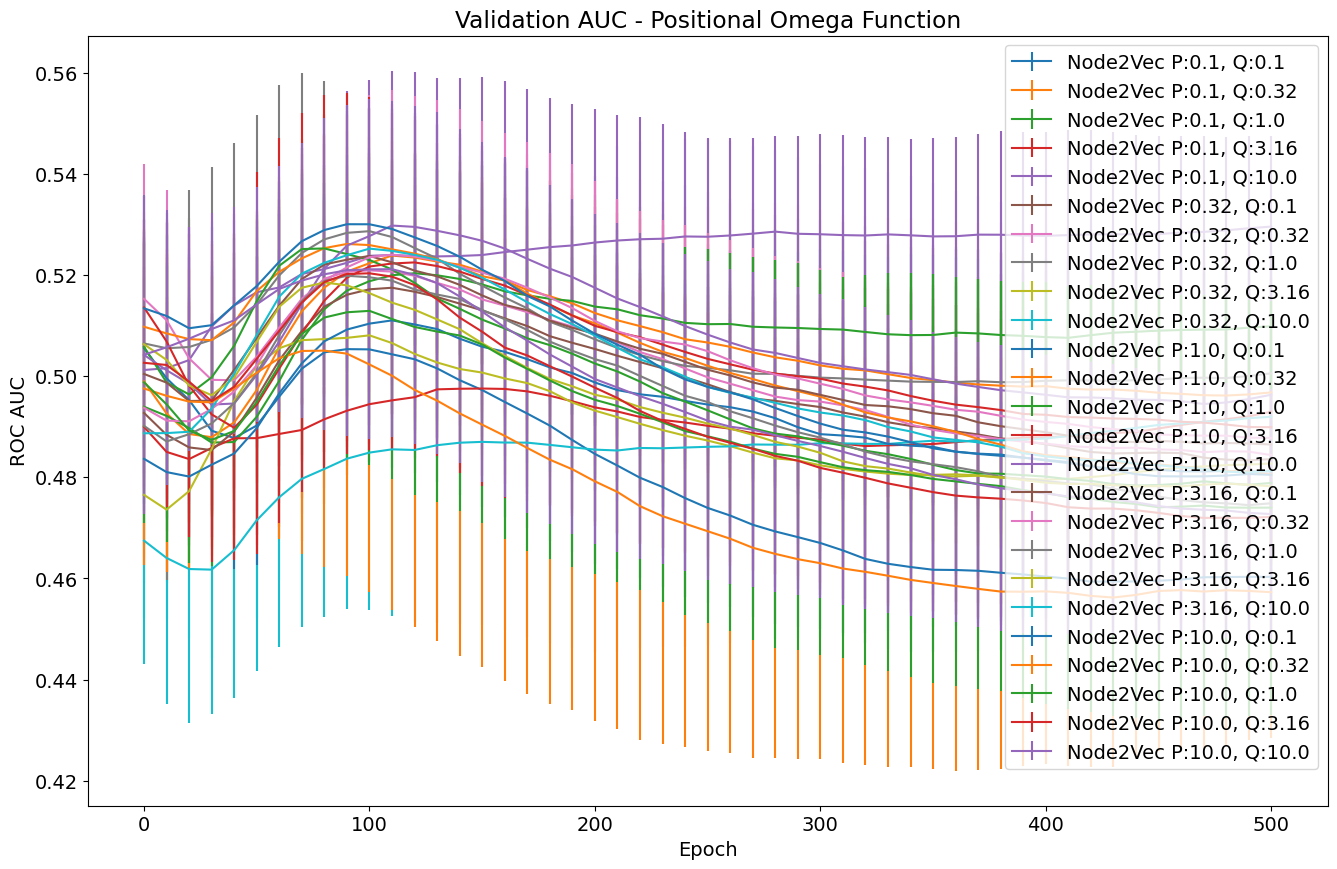

In [21]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

ax1.set_title('Validation AUC - Positional Omega Function')

for params in param_grid:
    param_tuple = tuple(params.items())
    ax1.errorbar(
        mean_auc_val_dict[param_tuple].index,
        mean_auc_val_dict[param_tuple],
        yerr=std_auc_val_dict[param_tuple],
        ls='-',
        label=f'Node2Vec P:{params["p"]}, Q:{params["q"]}')


# ax1.set_xlim(-50, 5000)

ax1.set_xlabel('Epoch')
ax1.set_ylabel('ROC AUC')

ax1.legend()

### Best AUC Heatmap

<AxesSubplot: xlabel='q', ylabel='p'>

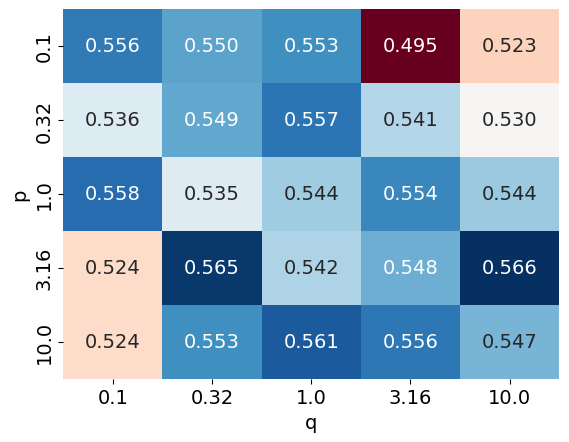

In [22]:
sns.heatmap(
    full_metrics_df.groupby(['p', 'q'])['auc_train'].max().unstack('q'),
    cmap='RdBu',
    annot=True,
    cbar=False,
    fmt='.3f')

<AxesSubplot: xlabel='q', ylabel='p'>

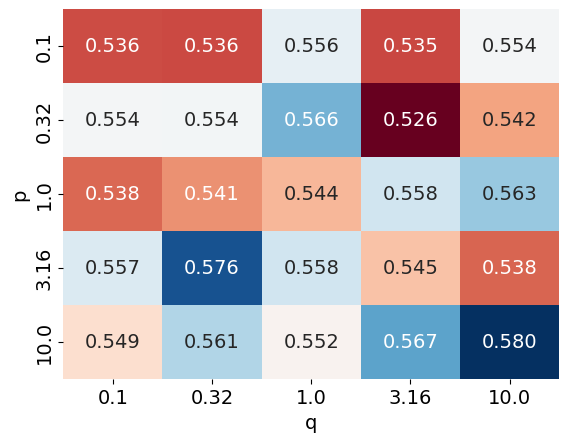

In [23]:
sns.heatmap(
    full_metrics_df.groupby(['p', 'q'])['auc_val'].max().unstack('q'),
    cmap='RdBu',
    annot=True,
    cbar=False,
    fmt='.3f')

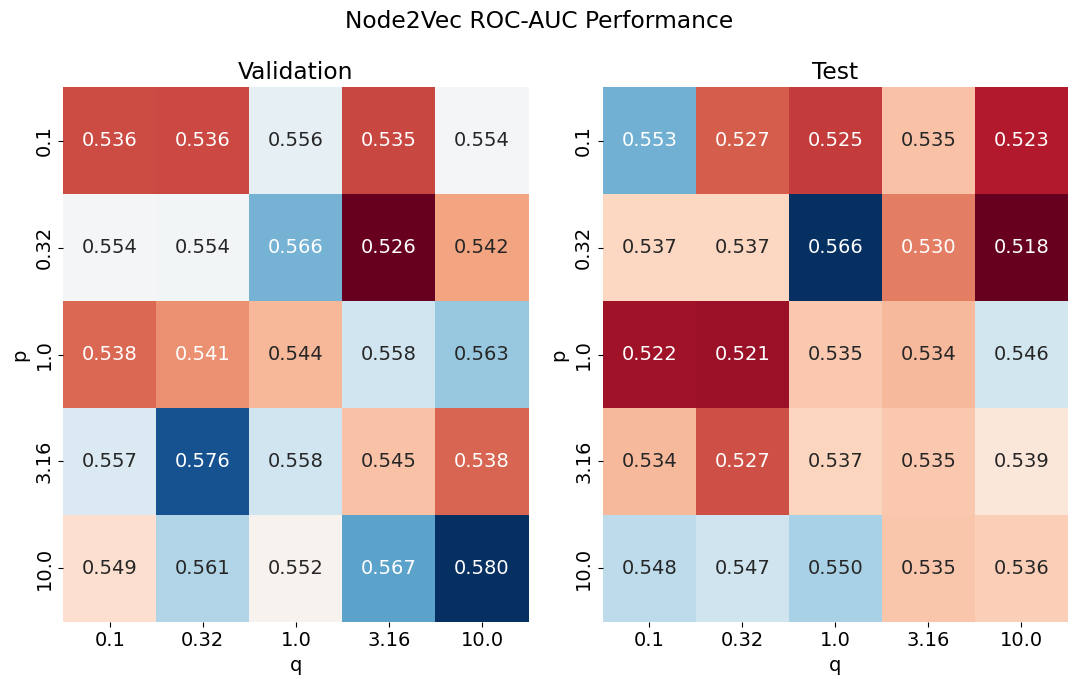

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 7))

fig.suptitle('Node2Vec ROC-AUC Performance')

sns.heatmap(
    full_metrics_df.groupby(['p', 'q'])['auc_val'].max().unstack('q'),
    cmap='RdBu',
    annot=True,
    cbar=False,
    fmt='.3f',
    ax=ax1
)

ax1.set_title('Validation')


sns.heatmap(
    full_metrics_df.groupby(['p', 'q'])['auc_test'].max().unstack('q'),
    cmap='RdBu',
    annot=True,
    cbar=False,
    fmt='.3f',
    ax=ax2,
)

ax2.set_title('Test')

plt.tight_layout()

plt.savefig(f'reports/images/citeseer/positional_omega_node2vec_rocauc_summary.pdf')

## Score Best model

In [25]:
best_model_metrics = full_metrics_df.sort_values('auc_val', ascending=False).iloc[0]
best_model_metrics

p                              10.0
q                              10.0
run                               0
epoch                           100
node2vec_loss    1.4851553440093994
loss_train                 1.293981
loss_val                   1.297193
loss_test                  1.299716
auc_train                  0.529514
auc_val                    0.579772
auc_test                   0.511192
Name: 10, dtype: object

In [26]:
best_model_metrics.to_json('models/positional_omega_node2vec/citeseer/best_model_info.json')